# Parameters

In [36]:
PREFIX = "TEST_10sec"

# Environment

In [37]:
from utils.noise_utils import (
    get_sounds,
    get_notes,
    sound_note_contains,
    get_data_loaders,
)
from utils.plot import plot_sounds
from lightning.pytorch import Trainer
from torchaudio.transforms import Spectrogram
from torch import device as torch_device, cuda, __version__

__version__

'2.0.0'

# Import data

In [38]:
sounds, names = get_sounds(
    records_dir=f"data/tensors/{PREFIX}_resized_records.pt",
    names_dir=f"data/tensors/{PREFIX}_records_names.xz",
)

sound_notes = get_notes(
    csv_dir="data/physionet.org/files/ephnogram/1.0.0/ECGPCGSpreadsheet.csv",
    id_col="Record Name",
    notes_col="PCG Notes",
    names=names,
)
labels = sound_note_contains(sound_notes, contains="Good")

sounds[0], names[0], labels[0]

(tensor([[-0.0064, -0.0044, -0.0049,  ...,  0.0147,  0.0142,  0.0137]]),
 'ECGPCG0016',
 tensor([1.]))

# Plot records

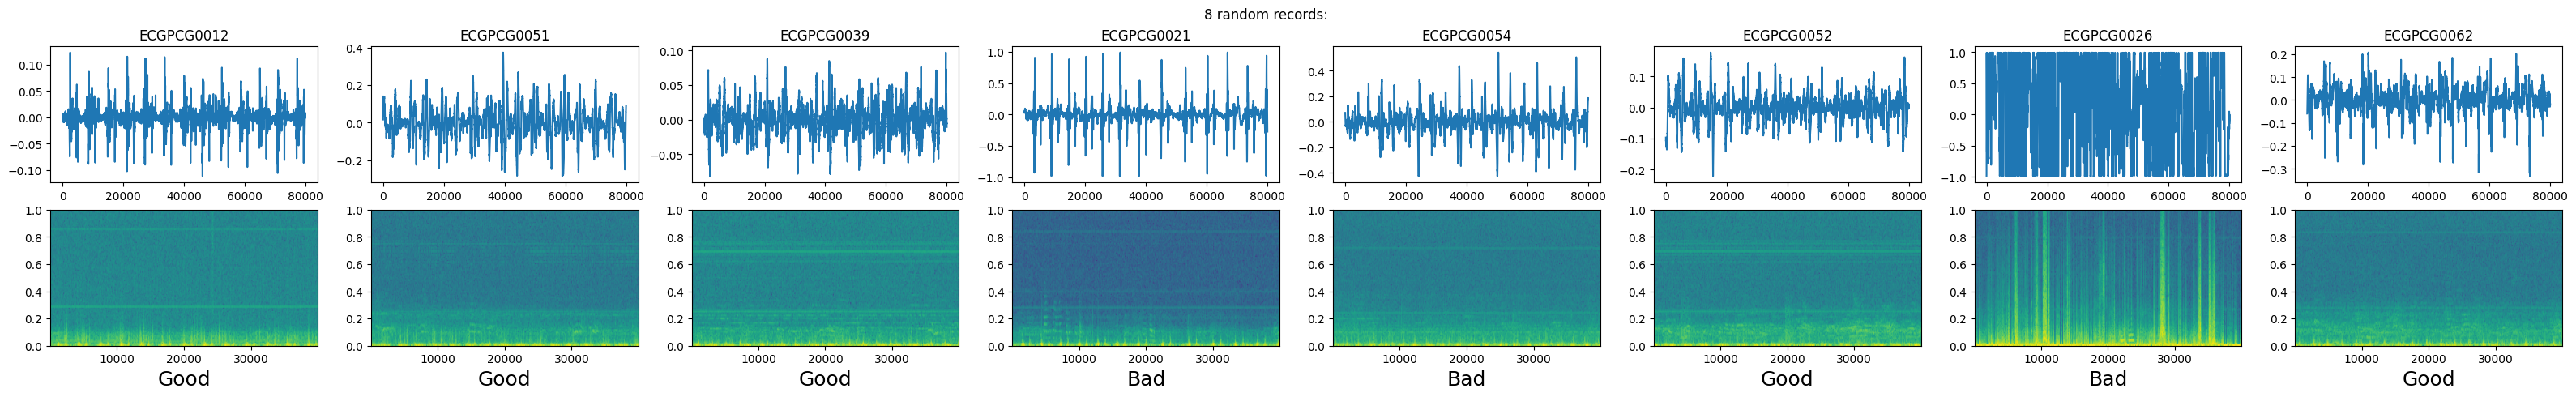

In [39]:
plot_sounds(
    sounds,
    names,
    labels,
    n=8,
    spectrogram=True,
    shuffle=True,
)

# Train and test

In [40]:
train, test = get_data_loaders(
    sounds,
    labels,
    batch_size=64,
    num_workers=1,
    transform=Spectrogram(),
)

train

# Try MNIST dataset

In [41]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_data = datasets.MNIST('./data', 
                            train = True, 
                            download = True,
                            transform = transf)

test_data = datasets.MNIST('./data', 
                            train = False, 
                            download = True,
                            transform = transf)

train = DataLoader(train_data, batch_size=256, shuffle=True)
test = DataLoader(test_data, batch_size=1024, shuffle=False)

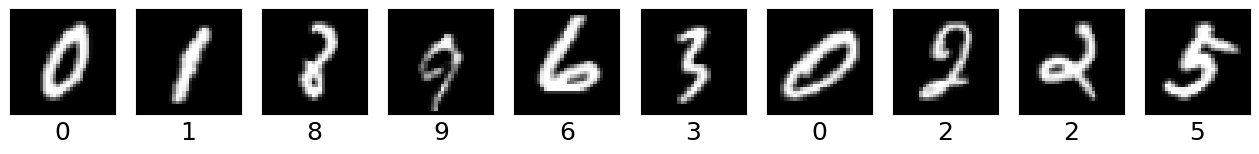

In [42]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,9))
data, target = next(iter(train))
for i in range(10):
    img = data.squeeze(1)[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(img, cmap="gray", interpolation="none")
    plt.xlabel(target[i].item(), fontsize=18)
    plt.xticks([])
    plt.yticks([])

# Model Architecture

In [54]:
from torch import flatten
from torch.optim import Adam
from torchmetrics import Accuracy
from collections import OrderedDict
from lightning.pytorch import LightningModule
from torch.nn import (
    Sequential,
    ReLU,
    LazyConv2d,
    MaxPool2d,
    LazyLinear,
    Sigmoid,
    BCEWithLogitsLoss,
    Conv2d,
    Linear,
    LogSoftmax,
    CrossEntropyLoss
)


class NoiseClassifier(LightningModule):
    def __init__(self, num_classes: int):
        super().__init__()
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        
        self.conv_net = Sequential(OrderedDict([
            ('C1', Conv2d(1, 6, kernel_size=(5, 5))),
            ('Relu1', ReLU()),
            
            ('S2', MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C3', Conv2d(6, 32, kernel_size=(5, 5))),
            ('Relu3', ReLU()),
            
            ('S4', MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('C5', Conv2d(32, 120, kernel_size=(5, 5))),
            ('Relu5', ReLU()),
        ]))
        
        self.fully_connected = Sequential(OrderedDict([
            ('F6', Linear(120, 84)),
            ('Relu6', ReLU()),
            ('F7', Linear(84, 10)),
            ('LogSoftmax', LogSoftmax(dim=-1))
        ]))
        
        
    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = flatten(output, start_dim=1)
        output = self.fully_connected(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        self.train_acc(y_hat, y)
        self.log("train_accuracy", self.train_acc, on_step=True, on_epoch=False)

        loss_fn = CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        self.val_acc(y_hat, y)
        self.log("val_accuracy", self.val_acc, on_step=True, on_epoch=False)

        loss_fn = CrossEntropyLoss()
        loss = loss_fn(y_hat, y)
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        return optimizer

In [55]:
device = torch_device("cuda" if cuda.is_available() else "cpu")

noise_classifier = NoiseClassifier(num_classes=10)
noise_classifier = noise_classifier.to(device)

# Train

In [56]:
noise_classifier

NoiseClassifier(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (conv_net): Sequential(
    (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (Relu1): ReLU()
    (S2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1))
    (Relu3): ReLU()
    (S4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C5): Conv2d(32, 120, kernel_size=(5, 5), stride=(1, 1))
    (Relu5): ReLU()
  )
  (fully_connected): Sequential(
    (F6): Linear(in_features=120, out_features=84, bias=True)
    (Relu6): ReLU()
    (F7): Linear(in_features=84, out_features=10, bias=True)
    (LogSoftmax): LogSoftmax(dim=-1)
  )
)

In [57]:
trainer = Trainer(limit_train_batches=100, max_epochs=10, log_every_n_steps=30)
trainer.fit(model=noise_classifier, train_dataloaders=train, val_dataloaders=test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type               | Params
-------------------------------------------------------
0 | train_acc       | MulticlassAccuracy | 0     
1 | val_acc         | MulticlassAccuracy | 0     
2 | conv_net        | Sequential         | 101 K 
3 | fully_connected | Sequential         | 11.0 K
-------------------------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.448     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 31.58it/s, v_num=2]        

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 31.49it/s, v_num=2]
